# Probabilistic Graphical Models as a Cybersecurity Tool

# Abstract 

This project is a small subset of tool application from the Georgetown Data Science and Analytics 5650 Computational Social Science course. It investigates how Probabilistic Graphical Models (PGMs) can be used not only for associational reasoning but as a first step toward causal inference in cybersecurity risk modeling. Using Bayesian networks and Markov chains, a simple use case demonstrates a simplified password guessing attack that operates through timing delays or error messages. Through Python simulations and the pgmpy library, we model the operative "attack" and visualization of probability to represent a more general appraoch to probabalistic attack surface management. Treating cyber vulnerabilities probabilistically and dynamically instead of deterministically is a proactive approach to managing cyber threats. 

Ultimately, this work illustrates how tools from computational social science can make cybersecurity systems more transparent and intelligible by modeling risk propagation, adversarial learning, and belief updates in a formal structure. Beyond the academic exercise, the approach could inform a "live" framework for managing cyber threats under uncertainty—bridging simulation, inference, and real-world decision-making.

# Introduction 

Cybersecurity threats are increasingly probabilistic, adaptive, and opaque. Attackers often rely on incomplete information, indirect signals, and iterative strategies: traits that can be captured by Probabilistic Graphical Models (PGMs), which offer a formalism for reasoning under uncertainty. PGMs, particularly Bayesian networks and Markov chains, enable compact representations of conditional dependencies and dynamic state transitions [@koller2009probabilistic].

In this project, we simulate a password guessing attack that leverages system feedback. Inspired by side-channel attack scenarios [@kocher1996timing], we use this toy model to explore how probabilistic inference can reconstruct hidden system states over time. The simulation incorporates both a prior belief over possible characters and a likelihood model informed by empirical or simulated timing data. We then encode the attacker’s belief update process as a Bayesian network using the pgmpy library, allowing for visualization and inference.

The project’s goal is twofold: (1) to model the adversarial learning process using formal tools from computational social science, and (2) to demonstrate how decision-relevant uncertainty evolves as attackers interact with system defenses. This mirrors the approach in Risk Assessment and Decision Analysis with Bayesian Networks [@fenton2018risk], which emphasizes real-world applications of PGMs for decision-making under uncertainty. Unlike traditional deterministic risk models, this probabilistic framework can be closer to a "real-time" risk management response where updated beliefs are modeled using a formal framework. 

By integrating simulation, graphical modeling, and Bayesian reasoning, this work contributes to the study of socio-technical risk systems and supports a reproducible, modular approach to reasoning about adversarial behavior.

# Demonstration

We start with one of the simplest possible cybersecurity tasks, a password hack. Many beginner applications contain login checks similar to this code: 

In [11]:
def insecure_check(user_input):
    secret = "hunter2"
    for i in range(len(user_input)):
        if i >= len(secret) or user_input[i] != secret[i]:
            return False
    return len(user_input) == len(secret)

In this code, if the first character is wrong, it returns immediately. If the first character is right, it moves to the second (etc.). 

This is a constant-time comparison. It is easy to implement insecurely, and easier to break in code that does not implement similar checks properly. Below is a sample script that measures the time it takes to check correct inputs - the timing for the system to check 'incorrect' versus 'correct' inputs is different, by monitoring those time deltas you can confirm that password characters are correct during entry before pressing "enter" to test the password input. 

## Pure Binary Timing Attack 

In [12]:
import time

def test_guess(password_guess):
    start = time.perf_counter()
    insecure_check(password_guess)
    end = time.perf_counter()
    return end - start


By systematically trying all letters for each position and measuring response time, you can build the password one character at a time. This is why secure code uses constant-time comparison functions like:

In [3]:
# import hmac
# hmac.compare_digest(user_input, secret)

# Password Guesser 
## Timing Model

We can represent this as a Bayesian Network or a Markov model, where each character guess is a node whose probability of correctness increases with the time it takes to reject the input. The underlying idea is that the longer the check takes, the more characters are likely to be correct. 

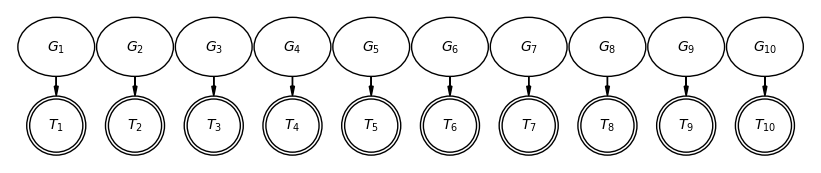

In [4]:
from timing_plot import plot_pgm
plot_pgm()

Bear with me through this example - this example, as demonstrated by the PGM above, makes it visually clear that each password component is considered separately. Each character, G, is guessed and then fed into a timing response loop, T. These help us to generate the predicted posterior, or likelihood of whether or not the binary character 0 or 1 is correct. 

In [5]:
from timing_model import (
    collect_timing_data,
    bin_timings,
    build_model,
    run_inference,
    suggest_password_guess,
    demo_timing_attack
)

# Quick demo
posteriors = demo_timing_attack("hunter2xyz")

# Or step by step
timings = collect_timing_data()
timing_classes = bin_timings(timings)
model = build_model()
posteriors = run_inference(model, timing_classes)
guess = suggest_password_guess(posteriors)
print(f"Binary guess: {guess}")

/Users/elizabethkovalchuk/Documents/dev_environments/miniforge3/envs/hack_demo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running timing attack demo on secret: hunter2xyz
Timing bins: [0, 0, 0, 1, 1, 1, 2, 2, 2, 2]
(0=short, 1=medium, 2=long)

Building model and running inference...

Results:
Position | P(Correct) | Actual
-----------------------------------
    1    |   0.125    |   h
    2    |   0.125    |   u
    3    |   0.125    |   n
    4    |   0.600    |   t
    5    |   0.600    |   e
    6    |   0.600    |   r
    7    |   0.857    |   2
    8    |   0.857    |   x
    9    |   0.857    |   y
   10    |   0.857    |   z

Suggested binary guess: 0001111111
(1 = likely correct, 0 = likely incorrect)
Binary guess: 0001111111


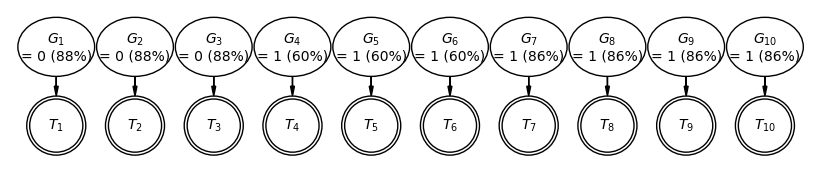

In [8]:
from timing_plot import plot_pgm
plot_pgm(posteriors)

Each node labeled G₁ through G₁₀ represents a latent variable indicating the true bit (0 or 1) at each position in the guessed password. The added annotation (e.g., = 0 (60%)) indicates the most probable value inferred for that variable, based on observed timing feedback. The percentage shows the model's confidence in that guess — in this example, G₄ = 0 (60%) means the model predicts the fourth bit is likely 0, with 60% posterior probability. This probabilistic interpretation is important because it captures the uncertainty in each inference step and can be used to adaptively refine guesses in future attack iterations. 

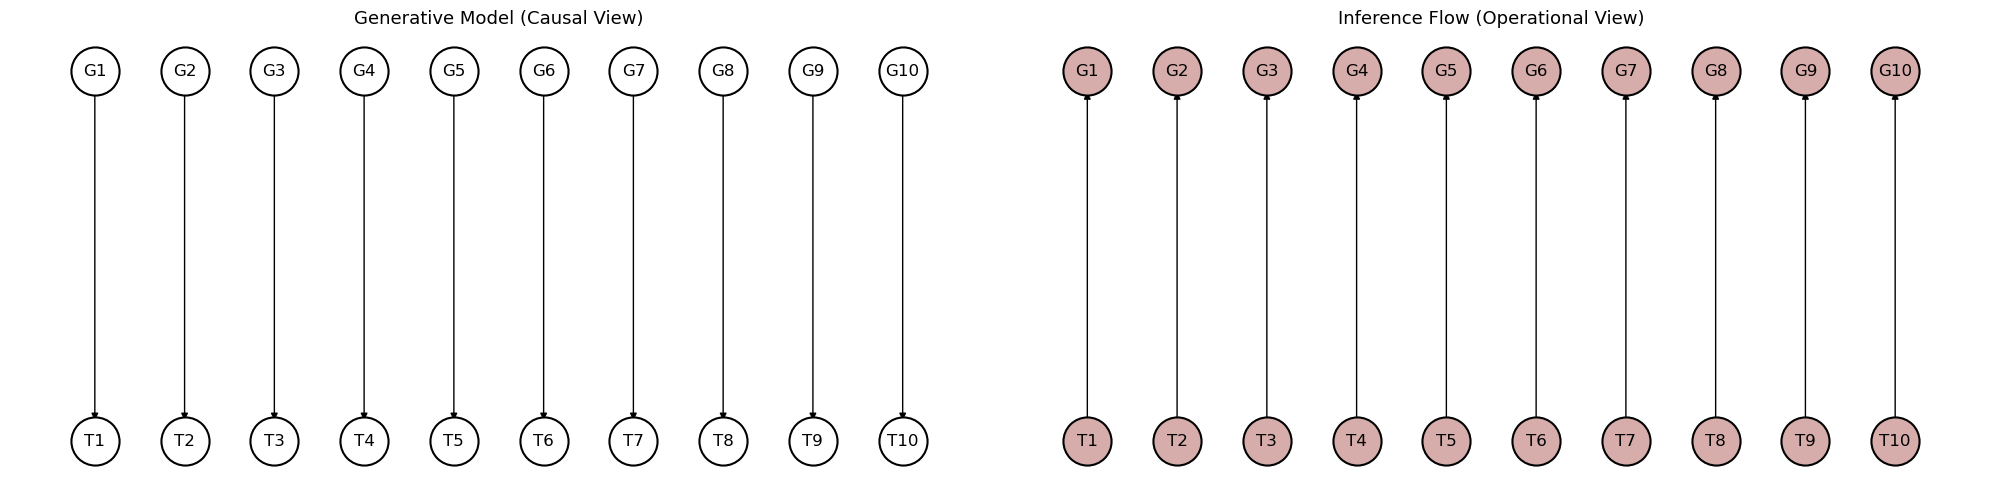

In [9]:
from timing_plot import plot_dual_pgm_views
plot_dual_pgm_views()


These results are pretty simple. The probabilities based on this basic code don't really give us a lot of confidence when we examine the suggested entry for the password check, do they? To try and provide something a little more realistic, we'll try another iteration using the PGM models to think about how we might show something more useful. Let's first include all lowercase letters, capital letters, 0-9, and special characters !@#$%^&* in our ten entry password guesser. It will also make more sense to try and update the next 'guess' based on what the previous timing response was. 

## Characters, and prior entry | Worldlike Model

In [10]:
from wordlike_plot import plot_wordlike_pgm
plot_wordlike_pgm(use_ngrams=True) # Plot with trigram support

Loading cached wordlists/rockyou_top2500.txt
Loading cached wordlists/english_words_4_12.txt


NameError: name 'CHARSET' is not defined

In [ ]:
from wordlike_model import build_wordlike_model, run_word_inference, suggest_wordlike_guess, CHARSET_INDEX

# Automatically uses large dataset (5000 words)
model = build_wordlike_model(use_ngrams=True)

# Test with vegetable
observed = {
    "G1": CHARSET_INDEX['v'],
    "G2": CHARSET_INDEX['e'],
    "G3": CHARSET_INDEX['g']
}

posteriors = run_word_inference(model, observed)
best_guess = suggest_wordlike_guess(posteriors, observed)
print(f"Suggested guess: {best_guess}")

Suggested guess: vegetableo


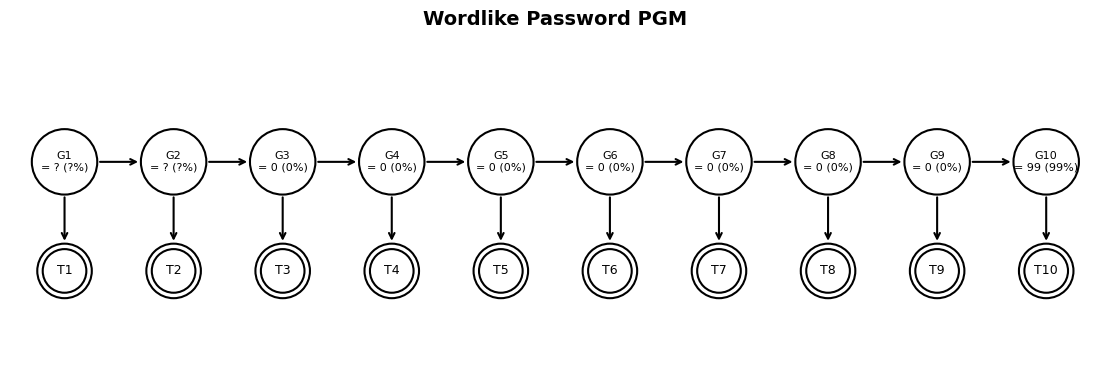

In [ ]:
from wordlike_plot import plot_wordlike_pgm_nx 
model = build_wordlike_model(use_ngrams=True)
observed = {"G1": CHARSET_INDEX["v"], "G2": CHARSET_INDEX["e"]}
posteriors = run_word_inference(model, observed)

plot_wordlike_pgm_nx(posteriors=posteriors)


## Password Guessing with Both Timing and Typing Dynamics | Hybrid Model

Now, to integrate the prior guess probabilities from the word model (wordlike_model) and the likelihood from timing data (timing_model).

In [ ]:
import numpy as np

def build_timing_cpd():
    """
    Returns a list-of-lists representing P(T_i | G_i) with shape (3, len(CHARSET))
    - Row 0: P(T=short | G)
    - Row 1: P(T=med   | G)
    - Row 2: P(T=long  | G)
    """
    len_charset = len(CHARSET)

    # Example: assume guesses that are more correct produce longer times
    # We'll say even-indexed guesses are "wrong" → short delay
    # and odd-indexed guesses are "right" → long delay
    cpd = np.zeros((len_charset, 3))

    for i in range(len_charset):
        if i % 2 == 0:
            cpd[i] = [0.6, 0.3, 0.1]  # wrong guess
        else:
            cpd[i] = [0.1, 0.3, 0.6]  # right guess

    return cpd.T  # Transpose to shape (3, len(CHARSET))


In [ ]:
from hybrid_model import build_hybrid_model, run_hybrid_inference
from wordlike_model import CHARSET
from timing_model import bin_timings, collect_timing_data
from wordlike_model import suggest_wordlike_guess

words = ["password", "hunter", "welcome", "admin", "vegetable", "dragon", "Monkey123!"]
timing = collect_timing_data("hunter2xyz")  # or real keystroke times
timing_classes = bin_timings(timing)

# Build timing CPD (dummy version for now)
timing_cpd = build_timing_cpd()  # You can calibrate this better later

# Build hybrid model
model = build_hybrid_model(words, timing_cpd)

# Run inference
posteriors = run_hybrid_inference(model, timing_classes)

# Suggest best guess
guess = suggest_wordlike_guess(posteriors)
print("Hybrid Suggested Password:", guess)


Hybrid Suggested Password: assworddb3


That password is actually depressingly realistic. 

## More Realistic Timing / Keystroke Data

The update will collect timing per character guess, then be labeled as correct or incorrect.

* Bin durations (e.g. into short/medium/long).
* Count occurrences of each bin per label.
* Normalize to compute the probably given $P(T_i \mid G_i)$

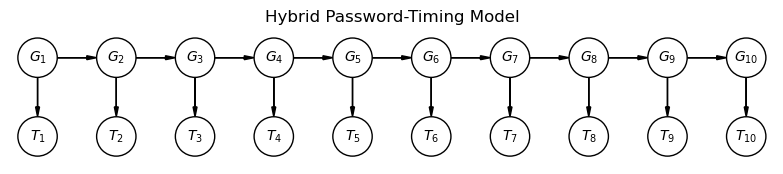

In [ ]:
from hybrid_plot import plot_hybrid_pgm

# For bigram-based character model
plot_hybrid_pgm(use_ngrams=False)

In [ ]:
from hybrid_model import build_hybrid_model, run_hybrid_inference
from wordlike_model import suggest_wordlike_guess, CHARSET
from timing_model import collect_timing_characterwise, simulate_wrong_timings, build_empirical_timing_cpd
import numpy as np

correct = collect_timing_characterwise("hunter2xyz")
incorrect = simulate_wrong_timings("hunter2xyz")

# Build CPD
timing_cpd = np.array(build_empirical_timing_cpd(correct, incorrect)).T  # shape (3, 70)

# Build model and infer
words = ["password", "hunter", "welcome", "admin", "vegetable"]
model = build_hybrid_model(words, timing_cpd)

timing_durations = [t[0] for t in correct]  # or from real data
from timing_model import bin_timings
timing_classes = bin_timings(timing_durations)

posteriors = run_hybrid_inference(model, timing_classes)
guess = suggest_wordlike_guess(posteriors)
print("Empirical hybrid guess:", guess)

Empirical hybrid guess: asswordeer


## Simulated Attack Model 

Now, we'll try to simulate an attack that: 
1. Starts with no knowledge.
2. Probes the system one character at a time.
3. Collects timing feedback after each probe.
4. Updates the PGM and refines guesses at each round.
5. Builds the password one character at a time by combining timing + language model.

In [ ]:
from timing_model import collect_timing_characterwise, simulate_wrong_timings, build_empirical_timing_cpd
from adaptive_attack import simulate_adaptive_attack
from wordlike_model import CHARSET

# Step 1: Gather timing data
correct = collect_timing_characterwise("hunter2xyz")
incorrect = simulate_wrong_timings("hunter2xyz")
timing_cpd = np.array(build_empirical_timing_cpd(correct, incorrect)).T

# Step 2: Simulate attack
words = ["password", "hunter", "welcome", "admin", "vegetable"]
simulate_adaptive_attack("hunter2xyz", words, timing_cpd, use_ngrams=True)


ModuleNotFoundError: No module named 'adaptive_attack'

## From PGM to Dynamic Bayesian Network: 

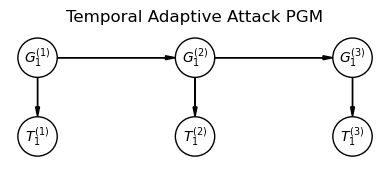

In [ ]:
from adaptive_plot_temporal import plot_temporal_adaptive_pgm
plot_temporal_adaptive_pgm(rounds=3)

Where each node contains a its own PGM. 

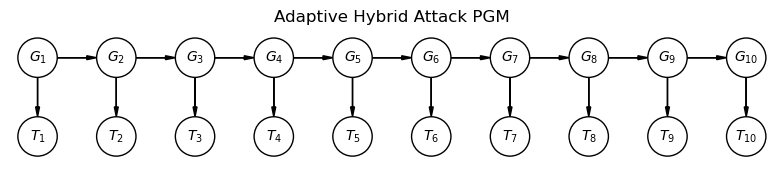

In [ ]:
from adaptive_plot_temporal import plot_adaptive_attack_pgm

# For bigram model
plot_adaptive_attack_pgm(use_ngrams=False)